### Imports

In [63]:
import fiona
import shapely.geometry
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from matplotlib.colors import Normalize

### Create basemap for plotting in matplotlib

In [64]:
ny_map = Basemap(projection='merc', lat_0=40.6, lon_0=-73.9, llcrnrlat=40.5,urcrnrlat=40.9, llcrnrlon=-74.3,urcrnrlon=-73.65,resolution='h', area_thresh=1)

### Create income table from census data and merge with the GEO_ID to match polygons with income

In [65]:
income_table = pd.read_csv('/Users/murdock/Documents/metis/MTABenson_metis/ACS_15_5YR_B19013_with_ann.csv')

In [66]:
income_table = income_table.drop(income_table.index[0])
income_table.columns=['GEO_ID', 'GEO_ID2', 'GEO_DISPLAY_LABEL', 'MEDIAN_INCOME', 'MARGIN_OF_ERROR']
income_table.head()

,GEO_ID,GEO_ID2,GEO_DISPLAY_LABEL,MEDIAN_INCOME,MARGIN_OF_ERROR
1,1500000US360050001000,360050001000,"Block Group 0, Census Tract 1, Bronx County, N...",-,**
2,1500000US360050001001,360050001001,"Block Group 1, Census Tract 1, Bronx County, N...",-,**
3,1500000US360050002000,360050002000,"Block Group 0, Census Tract 2, Bronx County, N...",-,**
4,1500000US360050002001,360050002001,"Block Group 1, Census Tract 2, Bronx County, N...",61344,14654
5,1500000US360050002002,360050002002,"Block Group 2, Census Tract 2, Bronx County, N...",71768,27738


In [67]:
filename = '/Users/murdock/Documents/metis/MTABenson_metis/thematic_map_shape/nyshapefile.shp'
blocks = []
with fiona.open(filename) as data:
    for block_data in data:
        geometry = shapely.geometry.shape(block_data['geometry'])
        block = block_data['properties']['GEO_ID']
        blocks.append([block, block_data['geometry']['coordinates'][0]])

In [68]:
df = pd.DataFrame(blocks, columns=['GEO_ID', 'COORDINATES'])
df.head()

,GEO_ID,COORDINATES
0,1500000US360850277023,"[(-74.16227899956263, 40.582589999880156), (-7..."
1,1500000US360850020021,"[(-74.07658999998112, 40.60600499974754), (-74..."
2,1500000US360470560003,"[(-73.95272400039974, 40.60634900018782), (-73..."
3,1500000US360050210011,"[(-73.85546499999606, 40.84222700024179), (-73..."
4,1500000US360810125002,"[(-73.9197729998709, 40.77231500021004), (-73...."


In [69]:
map_df = pd.merge(df, income_table, on='GEO_ID', how='left')
map_df.head()

,GEO_ID,COORDINATES,GEO_ID2,GEO_DISPLAY_LABEL,MEDIAN_INCOME,MARGIN_OF_ERROR
0,1500000US360850277023,"[(-74.16227899956263, 40.582589999880156), (-7...",360850277023,"Block Group 3, Census Tract 277.02, Richmond C...",50790,14223
1,1500000US360850020021,"[(-74.07658999998112, 40.60600499974754), (-74...",360850020021,"Block Group 1, Census Tract 20.02, Richmond Co...",84830,13999
2,1500000US360470560003,"[(-73.95272400039974, 40.60634900018782), (-73...",360470560003,"Block Group 3, Census Tract 560, Kings County,...",46295,10135
3,1500000US360050210011,"[(-73.85546499999606, 40.84222700024179), (-73...",360050210011,"Block Group 1, Census Tract 210.01, Bronx Coun...",46618,32505
4,1500000US360810125002,"[(-73.9197729998709, 40.77231500021004), (-73....",360810125002,"Block Group 2, Census Tract 125, Queens County...",60385,7017


In [70]:
map_df['MEDIAN_INCOME'] = map_df['MEDIAN_INCOME'].astype(int)

### Create figure and color code by normalizing the income for each shape

In [78]:
fig = plt.figure(figsize=(16, 16))
ax = fig.add_subplot(111)
ny_map.drawmapboundary(fill_color='aqua')
ny_map.fillcontinents(color='#f2f2f2',lake_color='aqua')
ny_map.drawcoastlines()

ny_map.readshapefile('/Users/murdock/Documents/metis/MTABenson_metis/thematic_map_shape/nyshapefile', 'nyshapefile')

cmap = plt.get_cmap('Oranges')

patches   = []

for info, shape in zip(ny_map.nyshapefile_info, ny_map.nyshapefile):
    patches.append(Polygon(np.array(shape), True))

norm = Normalize()
pc = PatchCollection(patches, zorder=2)
 
#pc.set_facecolor(cmap(norm(mapping_df['MEDIAN_INCOME'].fillna(0).values)))
pc.set_facecolor(cmap(norm(map_df['MEDIAN_INCOME'].fillna(0).values)))
ax.add_collection(pc)

mapper = matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap)

mapper.set_array(map_df['MEDIAN_INCOME'])
plt.colorbar(mapper, shrink=0.4)

plt.show()
#plt.savefig('NY_incomemap.png', bbox_inches='tight')

### Load table of selected train stations and plot these points on the income map

In [88]:
station_path = '/Users/murdock/Documents/Metis/MTABenson_metis/pklfiles/'
final_stations_df = pd.read_pickle(station_path + 'final_stations.pkl')

In [89]:
final_stations_df.head()

,STATION,STOP_NAME,LATITUDE,LONGITUDE,MEDIAN_INCOME
17,Delancey St,F,40.718611,-73.988114,93643
38,103 St,B C,40.796092,-73.961454,92121
21,Bedford Av,L,40.717304,-73.956872,90370
15,2 Av,F,40.723402,-73.989938,89398
42,Grand St,B D,40.718267,-73.993753,86957


### Plotting map with top stations overlaid as points on the map

In [85]:
ny_map_with_stations = Basemap(projection='merc', lat_0=40.6, lon_0=-73.9, llcrnrlat=40.67,urcrnrlat=40.83, llcrnrlon=-74.08,urcrnrlon=-73.9,resolution='h', area_thresh=1)

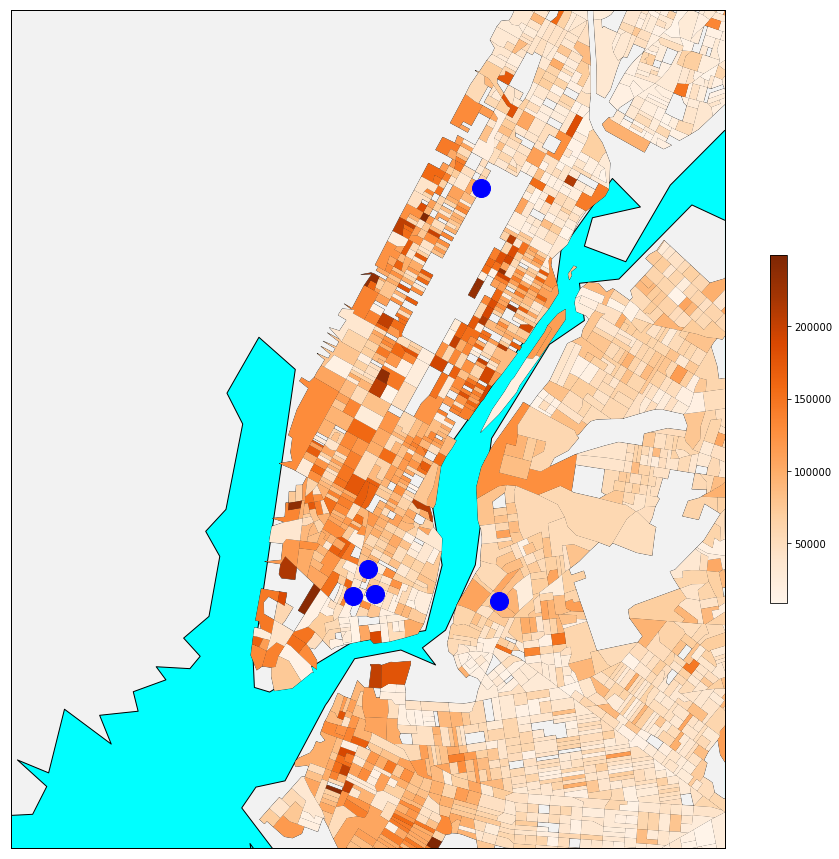

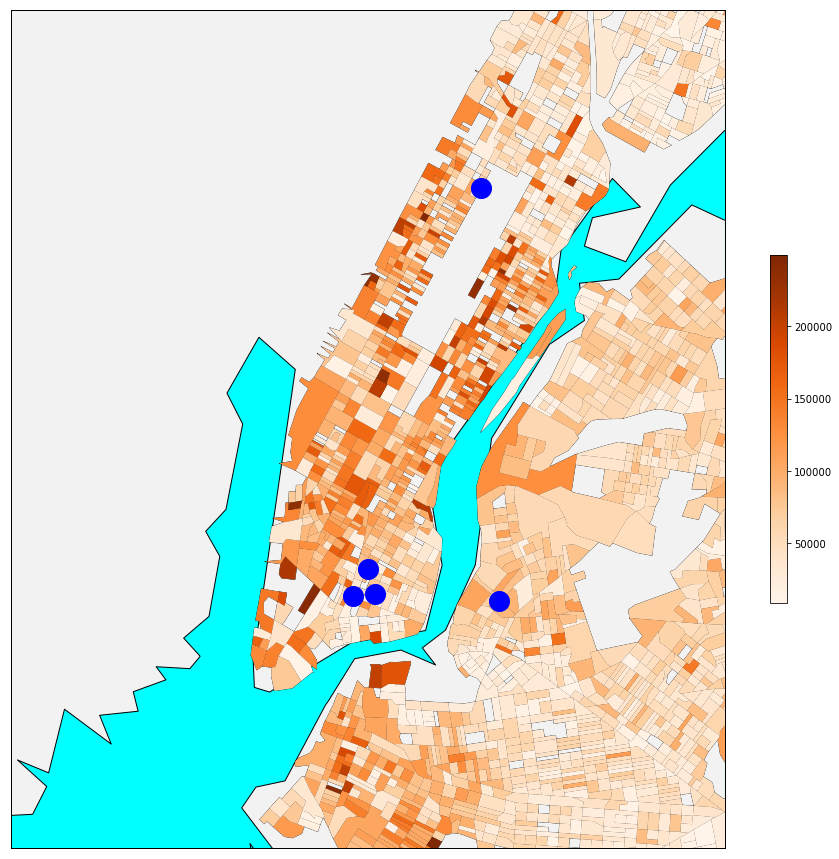

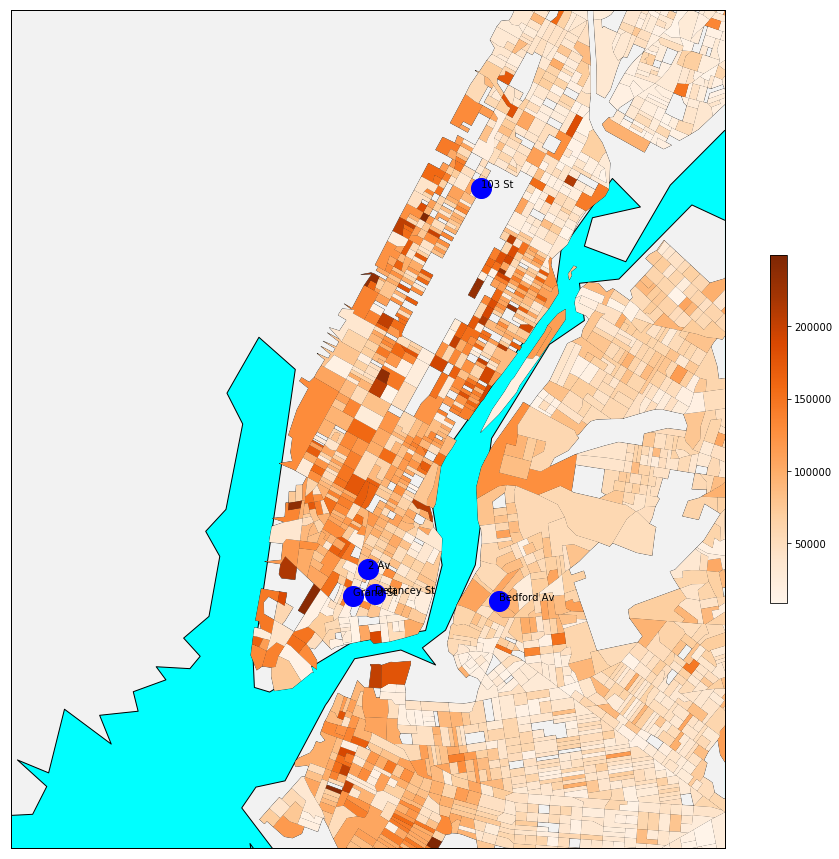

In [86]:
fig = plt.figure(figsize=(16, 16))
ax = fig.add_subplot(111)
ny_map_with_stations.drawmapboundary(fill_color='aqua')
ny_map_with_stations.fillcontinents(color='#f2f2f2',lake_color='aqua')
ny_map_with_stations.drawcoastlines()

ny_map_with_stations.readshapefile('/Users/murdock/Documents/metis/MTABenson_metis/thematic_map_shape/nyshapefile', 'nyshapefile')

cmap = plt.get_cmap('Oranges')

patches   = []

for info, shape in zip(ny_map_with_stations.nyshapefile_info, ny_map_with_stations.nyshapefile):
    patches.append(Polygon(np.array(shape), True))

norm = Normalize()
pc = PatchCollection(patches, zorder=2)
 
#pc.set_facecolor(cmap(norm(mapping_df['MEDIAN_INCOME'].fillna(0).values)))
pc.set_facecolor(cmap(norm(map_df['MEDIAN_INCOME'].fillna(0).values)))
ax.add_collection(pc)

lons = final_stations_df['LONGITUDE'].values
lats = final_stations_df['LATITUDE'].values
x, y = ny_map_with_stations(lons, lats)
ny_map_with_stations.plot(x, y, 'bo', markersize=20)

labels = [name for name in final_stations_df['STATION'].values]
for label, xpt, ypt in zip(labels, x, y):
    plt.text(xpt, ypt, label)

mapper = matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap)

mapper.set_array(map_df['MEDIAN_INCOME'])
plt.colorbar(mapper, shrink=0.4)

plt.show()
#plt.savefig('NY_incomemap_plus_stations.png', bbox_inches='tight')